In [ ]:
import nltk
import pandas as pd
import string
import pickle
import matplotlib.pyplot as plt
import seaborn as sns

from nltk.corpus import wordnet, stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer, WordNetLemmatizer
from nltk.tag import pos_tag
from nltk.probability import FreqDist

nltk.download('punkt_tab')
nltk.download('stopwords')
nltk.download('averaged_perceptron_tagger_eng')
nltk.download('wordnet')

[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger_eng to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger_eng is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [ ]:
stemmer = PorterStemmer()
lemmatizer = WordNetLemmatizer()
stop_words = stopwords.words('english')

Dataset diambil dari
https://www.kaggle.com/datasets/yasserh/twitter-tweets-sentiment-dataset

In [ ]:
df = pd.read_csv('/content/Tweets.csv')
df.head()

,textID,text,selected_text,sentiment
0,cb774db0d1,"I`d have responded, if I were going","I`d have responded, if I were going",neutral
1,549e992a42,Sooo SAD I will miss you here in San Diego!!!,Sooo SAD,negative
2,088c60f138,my boss is bullying me...,bullying me,negative
3,9642c003ef,what interview! leave me alone,leave me alone,negative
4,358bd9e861,"Sons of ****, why couldn`t they put them on t...","Sons of ****,",negative


In [ ]:
df.drop(['selected_text', 'textID'], axis=1, inplace=True)
df.head()

,text,sentiment
0,"I`d have responded, if I were going",neutral
1,Sooo SAD I will miss you here in San Diego!!!,negative
2,my boss is bullying me...,negative
3,what interview! leave me alone,negative
4,"Sons of ****, why couldn`t they put them on t...",negative


In [ ]:
display(df.isnull().sum())

,0
text,1
sentiment,0


Menghapus nilai null dan check value duplikat

In [ ]:
df.dropna(inplace=True)
df.duplicated().sum()

np.int64(0)

In [ ]:
display(df.isnull().sum())

,0
text,0
sentiment,0


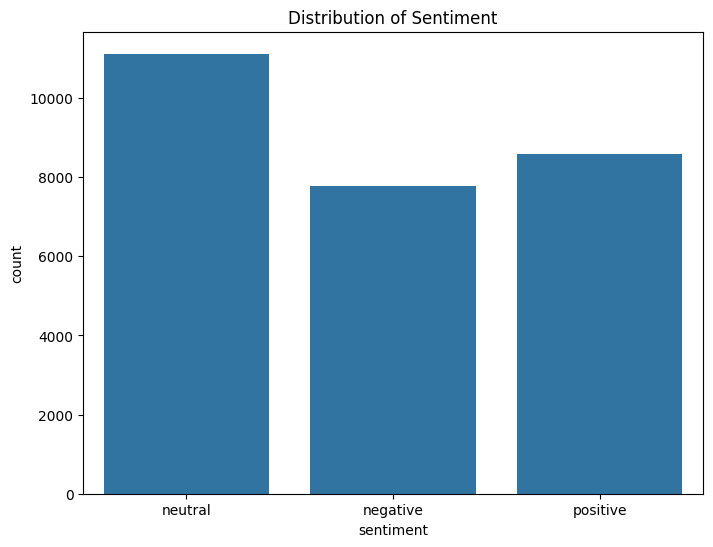

In [ ]:
plt.figure(figsize=(8, 6))
plt.title('Distribution of Sentiment')
sns.countplot(x='sentiment', data=df)
plt.show()

In [ ]:
import re

def normalize_text(text):
  text = text.lower()
  text = re.sub(r'[^\w\s]', '', text)  # Hapus karakter khusus
  text = re.sub(r'\d+', '', text)  # Hapus angka
  return text

df['processed_text'] = df['text'].apply(normalize_text)
df['processed_text'] = df['processed_text'].apply(word_tokenize) #Tokenisasi
df['processed_text'] = df['processed_text'].apply(lambda x: [word for word in x if word not in stop_words]) #Menghilangkan stopwords
df['processed_text'] = df['processed_text'].apply(lambda x: [lemmatizer.lemmatize(word) for word in x]) #Melakukan lemmatizing
df['processed_text'] = df['processed_text'].apply(lambda x: ' '.join(x)) #Menggabungkan kembali setiap token menjadi sebuah string

In [ ]:
df.head(10)

,text,sentiment,processed_text
0,"I`d have responded, if I were going",neutral,id responded going
1,Sooo SAD I will miss you here in San Diego!!!,negative,sooo sad miss san diego
2,my boss is bullying me...,negative,bos bullying
3,what interview! leave me alone,negative,interview leave alone
4,"Sons of ****, why couldn`t they put them on t...",negative,son couldnt put release already bought
5,http://www.dothebouncy.com/smf - some shameles...,neutral,httpwwwdothebouncycomsmf shameless plugging be...
6,2am feedings for the baby are fun when he is a...,positive,feeding baby fun smile coo
7,Soooo high,neutral,soooo high
8,Both of you,neutral,
9,Journey!? Wow... u just became cooler. hehe....,positive,journey wow u became cooler hehe possible


Ada kolom dengan isi blank pada bagian processed_text index ke 8 sehingga harus di remove untuk menghindari skewed result

In [ ]:
df = df[df['processed_text'] != '']

In [ ]:
df.head(10)

,text,sentiment,processed_text
0,"I`d have responded, if I were going",neutral,id responded going
1,Sooo SAD I will miss you here in San Diego!!!,negative,sooo sad miss san diego
2,my boss is bullying me...,negative,bos bullying
3,what interview! leave me alone,negative,interview leave alone
4,"Sons of ****, why couldn`t they put them on t...",negative,son couldnt put release already bought
5,http://www.dothebouncy.com/smf - some shameles...,neutral,httpwwwdothebouncycomsmf shameless plugging be...
6,2am feedings for the baby are fun when he is a...,positive,feeding baby fun smile coo
7,Soooo high,neutral,soooo high
9,Journey!? Wow... u just became cooler. hehe....,positive,journey wow u became cooler hehe possible
10,"as much as i love to be hopeful, i reckon the...",neutral,much love hopeful reckon chance minimal p im n...


Pembagian data 80% untuk training dan 20% untuk testing

In [ ]:
from sklearn.model_selection import train_test_split

X = df['processed_text']
y = df['sentiment']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer = TfidfVectorizer(ngram_range=(1,3))
X_train_vec = vectorizer.fit_transform(X_train)
X_test_vec = vectorizer.transform(X_test)

**Membuat Model**

MODEL 1 (Suport Vector Classifier Model)

In [ ]:
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, f1_score

In [ ]:
svm_model = SVC(kernel='linear')
svm_model.fit(X_train_vec, y_train)

SVC(kernel='linear')

In [ ]:
y_pred_svm = svm_model.predict(X_test_vec)

In [ ]:
accuracy_svm = accuracy_score(y_test, y_pred_svm)
f1_svm = f1_score(y_test, y_pred_svm, average='weighted')
print("Accuracy:", accuracy_svm)
print("F1 Score:", f1_svm)
print(classification_report(y_test, y_pred_svm))
print(confusion_matrix(y_test, y_pred_svm))

Accuracy: 0.7006381039197812
F1 Score: 0.7003068122182544
              precision    recall  f1-score   support

    negative       0.72      0.65      0.68      1588
     neutral       0.66      0.69      0.67      2180
    positive       0.74      0.77      0.75      1717

    accuracy                           0.70      5485
   macro avg       0.71      0.70      0.70      5485
weighted avg       0.70      0.70      0.70      5485

[[1025  452  111]
 [ 333 1500  347]
 [  69  330 1318]]


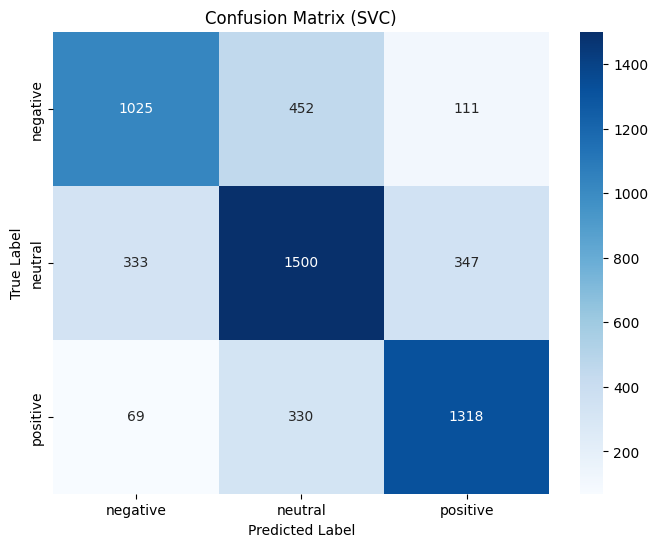

In [ ]:
cm_svm = confusion_matrix(y_test, y_pred_svm)
plt.figure(figsize=(8, 6))
sns.heatmap(cm_svm, annot=True, fmt="d", cmap="Blues",
            xticklabels=['negative', 'neutral', 'positive'],
            yticklabels=['negative', 'neutral', 'positive'])
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix (SVC)")
plt.show()

MODEL 2 (Multinomial Naive Bayes Model)

In [ ]:
from sklearn.naive_bayes import MultinomialNB
nb_model = MultinomialNB()

In [ ]:
nb_model.fit(X_train_vec, y_train)
y_pred_nb = nb_model.predict(X_test_vec)

In [ ]:
accuracy_nb = accuracy_score(y_test, y_pred_nb)
f1_nb = f1_score(y_test, y_pred_nb, average='weighted')
print("Accuracy (MultinomialNB):", accuracy_nb)
print("F1 Score (MultinomialNB):", f1_nb)
print(classification_report(y_test, y_pred_nb))
print(confusion_matrix(y_test, y_pred_nb))

Accuracy (MultinomialNB): 0.6036463081130355
F1 Score (MultinomialNB): 0.5842250659862466
              precision    recall  f1-score   support

    negative       0.85      0.31      0.45      1588
     neutral       0.51      0.89      0.65      2180
    positive       0.81      0.51      0.63      1717

    accuracy                           0.60      5485
   macro avg       0.72      0.57      0.58      5485
weighted avg       0.70      0.60      0.58      5485

[[ 487 1053   48]
 [  72 1943  165]
 [  13  823  881]]


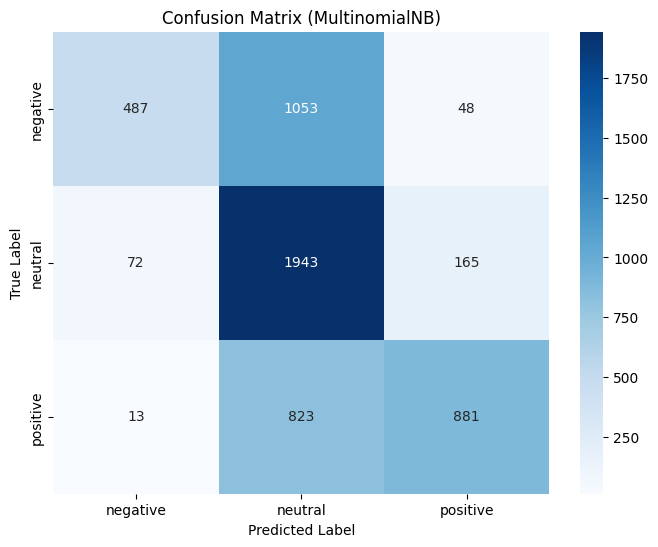

In [ ]:
cm_nb = confusion_matrix(y_test, y_pred_nb)
plt.figure(figsize=(8, 6))
sns.heatmap(cm_nb, annot=True, fmt="d", cmap="Blues",
            xticklabels=['negative', 'neutral', 'positive'],
            yticklabels=['negative', 'neutral', 'positive'])
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix (MultinomialNB)")
plt.show()

MODEL 3 (Logistic Regression Model)

In [ ]:
from sklearn.linear_model import LogisticRegression
lr_model = LogisticRegression(max_iter=1000) #menentukan jumlah iterasi

In [ ]:
lr_model.fit(X_train_vec, y_train)

LogisticRegression(max_iter=1000)

In [ ]:
y_pred_lr = lr_model.predict(X_test_vec)

In [ ]:
accuracy_lr = accuracy_score(y_test, y_pred_lr)
f1_lr = f1_score(y_test, y_pred_lr, average='weighted')
print("Accuracy (Logistic Regression):", accuracy_lr)
print("F1 Score (Logistic Regression):", f1_lr)
print(classification_report(y_test, y_pred_lr))
print(confusion_matrix(y_test, y_pred_lr))

Accuracy (Logistic Regression): 0.686052871467639
F1 Score (Logistic Regression): 0.6857595550580338
              precision    recall  f1-score   support

    negative       0.72      0.60      0.65      1588
     neutral       0.63      0.71      0.67      2180
    positive       0.74      0.74      0.74      1717

    accuracy                           0.69      5485
   macro avg       0.70      0.68      0.69      5485
weighted avg       0.69      0.69      0.69      5485

[[ 954  517  117]
 [ 307 1542  331]
 [  67  383 1267]]


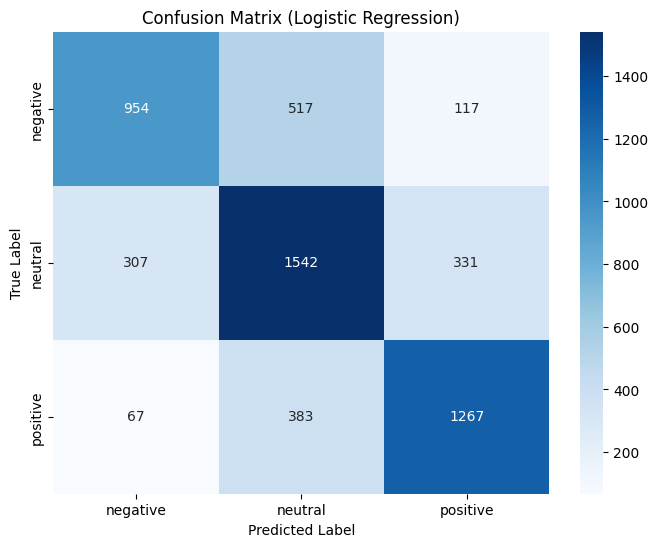

In [ ]:
cm_lr = confusion_matrix(y_test, y_pred_lr)
plt.figure(figsize=(8, 6))
sns.heatmap(cm_lr, annot=True, fmt="d", cmap="Blues",
            xticklabels=['negative', 'neutral', 'positive'],
            yticklabels=['negative', 'neutral', 'positive'])
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix (Logistic Regression)")
plt.show()

MODEL 4 (Random Forest Model)

In [ ]:
from sklearn.ensemble import RandomForestClassifier
rf_model = RandomForestClassifier(n_estimators=100) #menentukan jumlah pohon

In [ ]:
rf_model.fit(X_train_vec, y_train)
y_pred_rf = rf_model.predict(X_test_vec)

In [ ]:
accuracy_rf = accuracy_score(y_test, y_pred_rf)
f1_rf = f1_score(y_test, y_pred_rf, average='weighted')
print("Accuracy (Random Forest):", accuracy_rf)
print("F1 Score (Random Forest):", f1_rf)
print(classification_report(y_test, y_pred_rf))
print(confusion_matrix(y_test, y_pred_rf))

Accuracy (Random Forest): 0.6758432087511395
F1 Score (Random Forest): 0.6741967105199707
              precision    recall  f1-score   support

    negative       0.77      0.52      0.62      1588
     neutral       0.59      0.79      0.68      2180
    positive       0.77      0.68      0.72      1717

    accuracy                           0.68      5485
   macro avg       0.71      0.66      0.67      5485
weighted avg       0.70      0.68      0.67      5485

[[ 827  684   77]
 [ 200 1713  267]
 [  52  498 1167]]


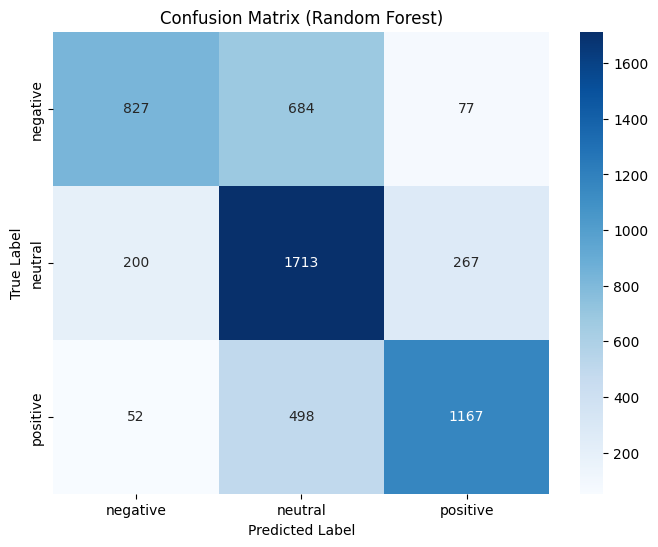

In [ ]:
cm_rf = confusion_matrix(y_test, y_pred_rf)
plt.figure(figsize=(8, 6))
sns.heatmap(cm_rf, annot=True, fmt="d", cmap="Blues",
            xticklabels=['negative', 'neutral', 'positive'],
            yticklabels=['negative', 'neutral', 'positive'])
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix (Random Forest)")
plt.show()

MODEL 5 (Long Short-Term Memory Model (deep learning model))

Pada model LSTM ini, saya menggunakan data preprocessing yang berbeda karena preprocessing seperti stemming/lemmatization seperti pada model tradisional bisa merusak urutan kata. ini penting untuk LSTM yang belajar dari sequence. Stopword removal yang dilakukan pada model tradisional juga bisa membuang kata-kata penting bagi konteks (misalnya: “not” dalam “not good”).

In [ ]:
!pip install tensorflow

In [ ]:
import numpy as np
import re
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import classification_report
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout, Bidirectional
from tensorflow.keras.callbacks import EarlyStopping

# Membersihkan data
def clean_text(text):
    text = text.lower()
    text = re.sub(r"http\S+|www\S+|https\S+", '', text)
    text = re.sub(r"@\w+|#", '', text)
    text = re.sub(r"[^a-zA-Z\s]", '', text)
    text = re.sub(r"\s+", ' ', text).strip()
    return text

df['text'] = df['text'].astype(str).apply(clean_text)

# Mempersiapkan data texts dan labels
texts = df['text'].values
labels = df['sentiment'].values

# Mengencode labels
le = LabelEncoder()
labels = le.fit_transform(labels)

# Tokenize dan pad sequences (padding digunakan untuk menyamakan semua input dengan panjang tertentu)
tokenizer = Tokenizer(num_words=20000, oov_token="<OOV>")
tokenizer.fit_on_texts(texts)
sequences = tokenizer.texts_to_sequences(texts)
padded = pad_sequences(sequences, maxlen=100, padding='post')

# Splitting data untuk training dan testing
X_train, X_test, y_train, y_test = train_test_split(padded, labels, test_size=0.2, random_state=42)

# Menghitung class weights (Untuk menyeimbangkan bobot setiap kelas)
class_weights = compute_class_weight(class_weight='balanced', classes=np.unique(y_train), y=y_train)
class_weights = dict(enumerate(class_weights))

# Building LSTM model
model = Sequential([
    Embedding(input_dim=20000, output_dim=128, input_length=100),
    Bidirectional(LSTM(128, return_sequences=True)),
    Dropout(0.5),
    Bidirectional(LSTM(64)),
    Dropout(0.5),
    Dense(3, activation='softmax')
])
# Bidirectional LSTM adalah LSTM dua arah untuk menangkap konteks dari depan dan belakang
# Activation function yang digunakan adalah softmax karena label memiliki 3 output yang berarti multi class bukan binary

model.build(input_shape=(None, 100))
model.summary()

model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

# Training menggunakan early stopping
early_stop = EarlyStopping(monitor='val_accuracy', patience=3, restore_best_weights=True)

history = model.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    epochs=10,
    batch_size=32,
    class_weight=class_weights,
    callbacks=[early_stop]
)

# Evaluate model
y_pred = model.predict(X_test)
y_pred_labels = np.argmax(y_pred, axis=1)

print(classification_report(y_test, y_pred_labels, target_names=le.classes_))

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ (None, 100, 128)       │     2,560,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional (Bidirectional)   │ (None, 100, 256)       │       263,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 100, 256)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_1 (Bidirectional) │ (None, 128)            │       164,352 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 3)              │           387 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,987,907 (11.40 MB)

 Trainable params: 2,987,907 (11.40 MB)

 Non-trainable params: 0 (0.00 B)

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ (None, 100, 128)       │     2,560,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional (Bidirectional)   │ (None, 100, 256)       │       263,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 100, 256)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_1 (Bidirectional) │ (None, 128)            │       164,352 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 3)              │           387 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,987,907 (11.40 MB)

 Trainable params: 2,987,907 (11.40 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
686/686 ━━━━━━━━━━━━━━━━━━━━ 30s 23ms/step - accuracy: 0.5275 - loss: 0.9168 - val_accuracy: 0.6964 - val_loss: 0.7059
Epoch 2/10
686/686 ━━━━━━━━━━━━━━━━━━━━ 35s 23ms/step - accuracy: 0.7683 - loss: 0.5607 - val_accuracy: 0.7170 - val_loss: 0.6869
Epoch 3/10
686/686 ━━━━━━━━━━━━━━━━━━━━ 16s 23ms/step - accuracy: 0.8470 - loss: 0.3962 - val_accuracy: 0.7028 - val_loss: 0.7645
Epoch 4/10
686/686 ━━━━━━━━━━━━━━━━━━━━ 17s 25ms/step - accuracy: 0.8915 - loss: 0.3016 - val_accuracy: 0.6870 - val_loss: 0.8733
Epoch 5/10
686/686 ━━━━━━━━━━━━━━━━━━━━ 20s 24ms/step - accuracy: 0.9182 - loss: 0.2301 - val_accuracy: 0.6946 - val_loss: 1.0194
172/172 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step
              precision    recall  f1-score   support

    negative       0.70      0.73      0.71      1588
     neutral       0.69      0.66      0.67      2180
    positive       0.77      0.78      0.78      1717

    accuracy                           0.72      5485
   macro avg       0.72      0.72   

In [ ]:
accuracy_lstm = accuracy_score(y_test, y_pred_labels)
f1_lstm = f1_score(y_test, y_pred_labels, average='weighted')
print("Accuracy (LSTM):", accuracy_lstm)
print("F1 Score (LSTM):", f1_lstm)
print(confusion_matrix(y_test, y_pred_labels))

Accuracy (LSTM): 0.7170464904284412
F1 Score (LSTM): 0.7164470866316137
[[1155  351   82]
 [ 423 1431  326]
 [  76  294 1347]]


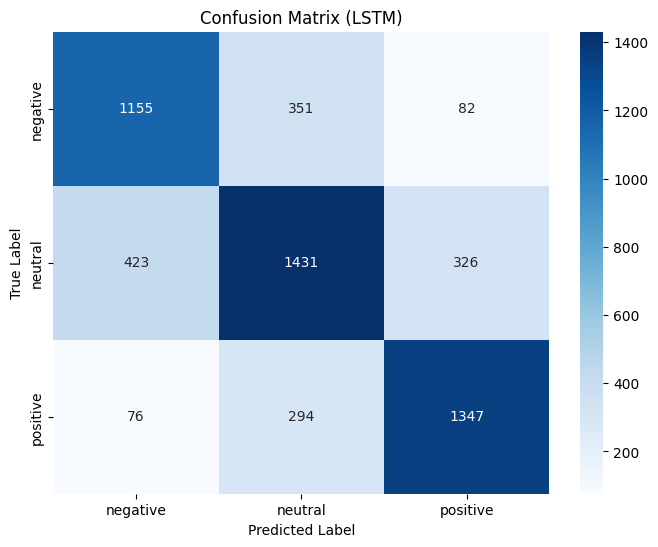

In [ ]:
cm_lstm = confusion_matrix(y_test, y_pred_labels)
plt.figure(figsize=(8, 6))
sns.heatmap(cm_lstm, annot=True, fmt="d", cmap="Blues",
            xticklabels=['negative', 'neutral', 'positive'],
            yticklabels=['negative', 'neutral', 'positive'])
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix (LSTM)")
plt.show()

MODEL 6 (Gated Recurrent Unit Model (deep learning model))

Pada model GRU ini, saya menggunakan preprocessing data yang sama dengan model LTSM dan arsitektur yang hampir sama

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, GRU, Dense, Dropout, Bidirectional

# Modeling GRU
gru_model = Sequential([
    Embedding(input_dim=20000, output_dim=128, input_length=100),
    Bidirectional(GRU(128, return_sequences=True)),
    Dropout(0.5),
    Bidirectional(GRU(64)),
    Dropout(0.5),
    Dense(3, activation='softmax')
])

gru_model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
gru_model.summary()

# Training GRU model
early_stop_gru = EarlyStopping(monitor='val_accuracy', patience=3, restore_best_weights=True)

history_gru = gru_model.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    epochs=10,
    batch_size=32,
    class_weight=class_weights,
    callbacks=[early_stop_gru]
)

# Evaluasi
y_pred_gru = gru_model.predict(X_test)
y_pred_labels_gru = np.argmax(y_pred_gru, axis=1)

print(classification_report(y_test, y_pred_labels_gru, target_names=le.classes_))

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_1 (Embedding)         │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_2 (Bidirectional) │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_3 (Bidirectional) │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
686/686 ━━━━━━━━━━━━━━━━━━━━ 21s 25ms/step - accuracy: 0.5169 - loss: 0.9254 - val_accuracy: 0.6848 - val_loss: 0.7145
Epoch 2/10
686/686 ━━━━━━━━━━━━━━━━━━━━ 39s 52ms/step - accuracy: 0.7684 - loss: 0.5511 - val_accuracy: 0.7074 - val_loss: 0.7303
Epoch 3/10
686/686 ━━━━━━━━━━━━━━━━━━━━ 22s 24ms/step - accuracy: 0.8556 - loss: 0.3744 - val_accuracy: 0.7070 - val_loss: 0.7583
Epoch 4/10
686/686 ━━━━━━━━━━━━━━━━━━━━ 15s 22ms/step - accuracy: 0.9022 - loss: 0.2785 - val_accuracy: 0.6928 - val_loss: 0.8788
Epoch 5/10
686/686 ━━━━━━━━━━━━━━━━━━━━ 15s 22ms/step - accuracy: 0.9259 - loss: 0.2118 - val_accuracy: 0.6837 - val_loss: 0.9683
172/172 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step
              precision    recall  f1-score   support

    negative       0.68      0.74      0.71      1588
     neutral       0.71      0.60      0.65      2180
    positive       0.73      0.81      0.77      1717

    accuracy                           0.71      5485
   macro avg       0.71      0.72    

In [ ]:
accuracy_gru = accuracy_score(y_test, y_pred_labels_gru)
f1_gru = f1_score(y_test, y_pred_labels_gru, average='weighted')
print("Accuracy (GRU):", accuracy_gru)
print("F1 Score (GRU):", f1_gru)
print(confusion_matrix(y_test, y_pred_labels_gru))

Accuracy (GRU): 0.707383773928897
F1 Score (GRU): 0.7047570502387906
[[1176  309  103]
 [ 459 1317  404]
 [  90  240 1387]]


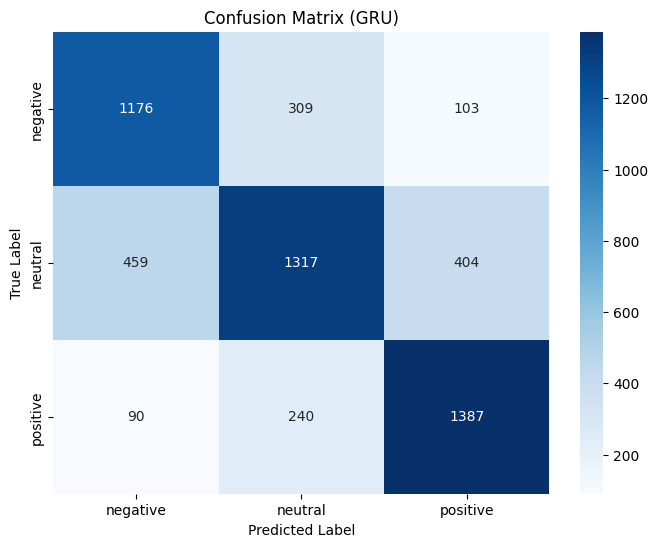

In [ ]:
cm_gru = confusion_matrix(y_test, y_pred_labels_gru)
plt.figure(figsize=(8, 6))
sns.heatmap(cm_gru, annot=True, fmt="d", cmap="Blues",
            xticklabels=['negative', 'neutral', 'positive'],
            yticklabels=['negative', 'neutral', 'positive'])
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix (GRU)")
plt.show()

**EVALUASI dan Hasil Training Model**

In [ ]:
model_names = ['SVC', 'MultinomialNB', 'Logistic Regression', 'Random Forest', 'LSTM', 'GRU']

In [ ]:
from sklearn.metrics import accuracy_score, classification_report, f1_score, roc_auc_score
f1_scores = [f1_svm, f1_nb, f1_lr, f1_rf, f1_lstm, f1_gru]
accuracy_scores = [accuracy_svm, accuracy_nb, accuracy_lr, accuracy_rf, accuracy_lstm, accuracy_gru]

Visualisasi dengan grafik

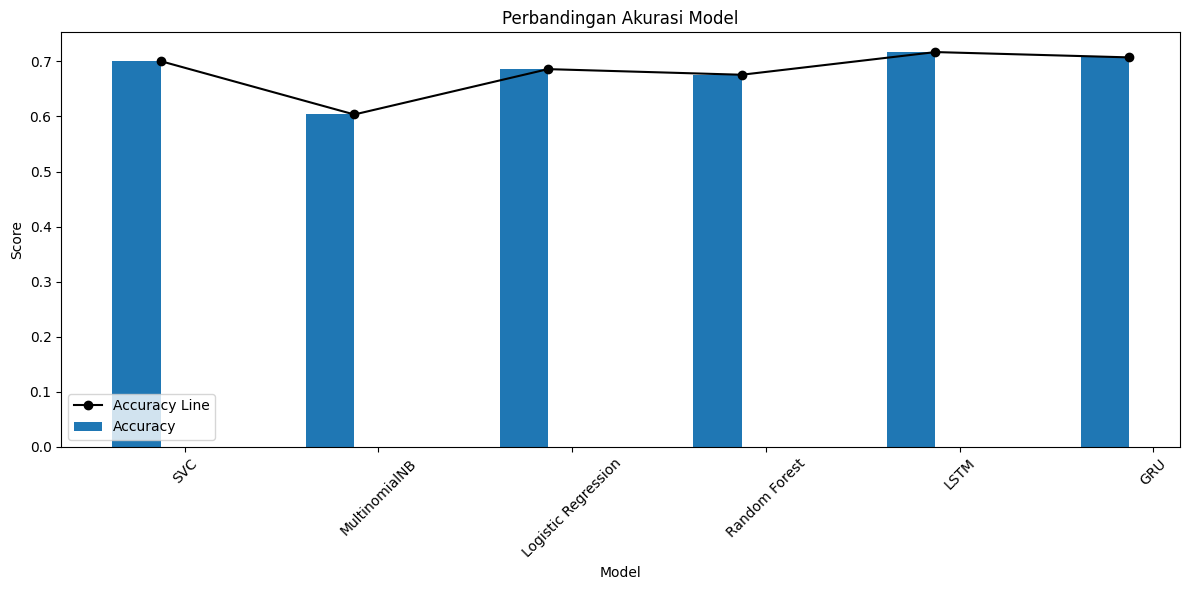

[0.7006381039197812, 0.6036463081130355, 0.686052871467639, 0.6758432087511395, 0.7170464904284412, 0.707383773928897]


In [ ]:
import numpy as np

bar_width = 0.25
index = np.arange(len(model_names))

fig, ax = plt.subplots(figsize=(12, 6))
ax.bar(index, accuracy_scores, bar_width, label='Accuracy')
ax.plot(index + bar_width/2, accuracy_scores, marker='o', linestyle='-', color='black', label='Accuracy Line')

ax.set_xlabel('Model')
ax.set_ylabel('Score')
ax.set_title('Perbandingan Akurasi Model')
ax.set_xticks(index + bar_width, model_names, rotation=45)
ax.legend()
plt.tight_layout()
plt.show()

print(accuracy_scores)

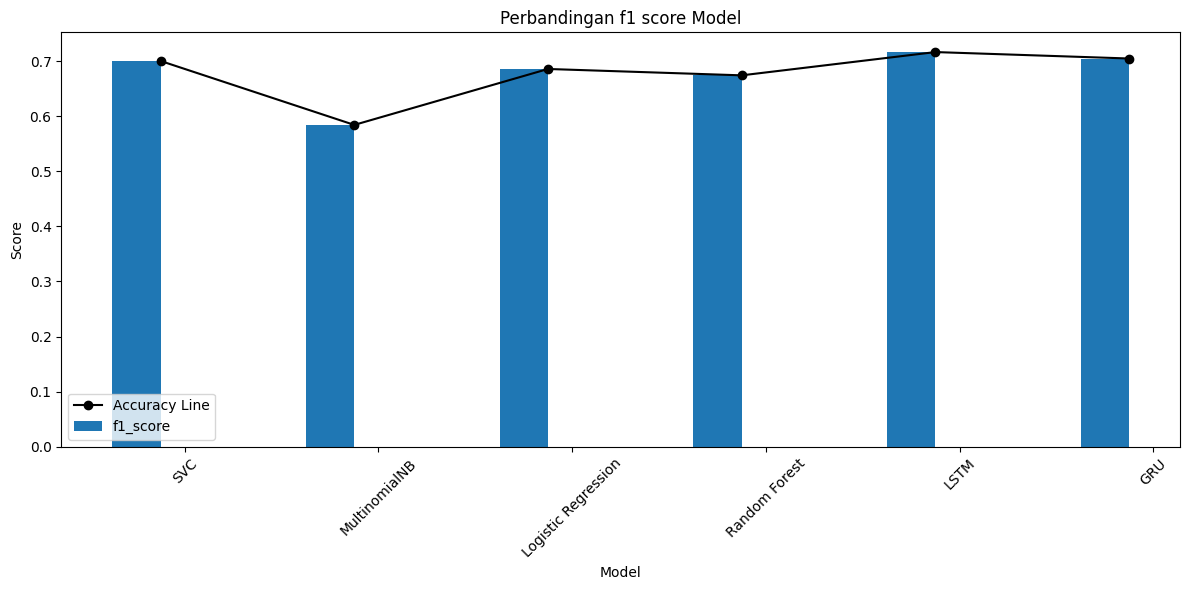

[0.7003068122182544, 0.5842250659862466, 0.6857595550580338, 0.6741967105199707, 0.7164470866316137, 0.7047570502387906]


In [ ]:
import numpy as np

bar_width = 0.25
index = np.arange(len(model_names))

fig, ax = plt.subplots(figsize=(12, 6))
ax.bar(index, f1_scores, bar_width, label='f1_score')
ax.plot(index + bar_width/2, f1_scores, marker='o', linestyle='-', color='black', label='Accuracy Line')

ax.set_xlabel('Model')
ax.set_ylabel('Score')
ax.set_title('Perbandingan f1 score Model')
ax.set_xticks(index + bar_width, model_names, rotation=45)
ax.legend()
plt.tight_layout()
plt.show()

print(f1_scores)

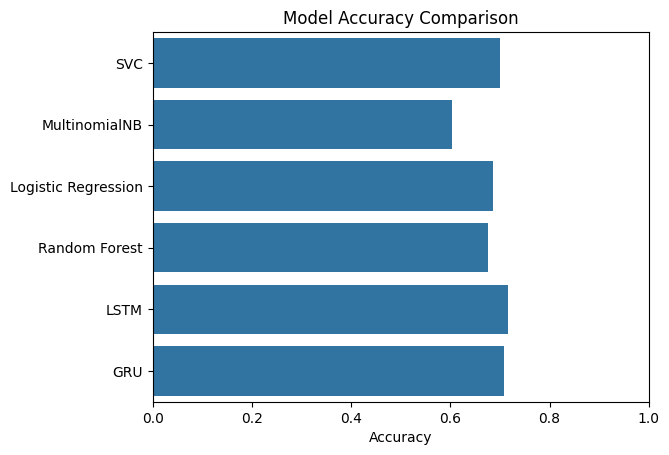

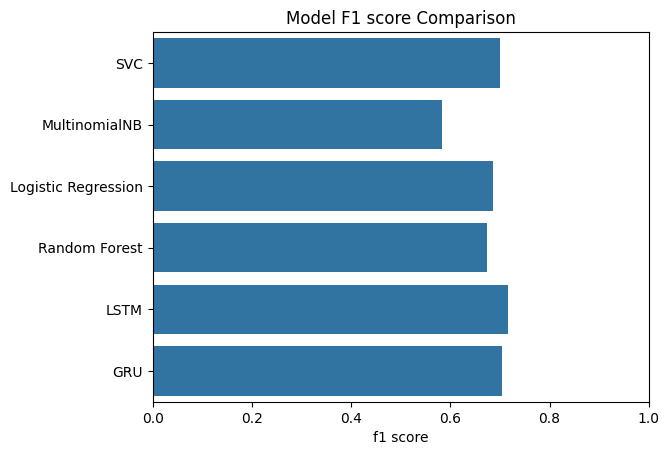

In [ ]:
sns.barplot(x=accuracy_scores, y=model_names)
plt.title("Model Accuracy Comparison")
plt.xlabel("Accuracy")
plt.xlim(0, 1)
plt.show()

sns.barplot(x=f1_scores, y=model_names)
plt.title("Model F1 score Comparison")
plt.xlabel("f1 score")
plt.xlim(0, 1)
plt.show()

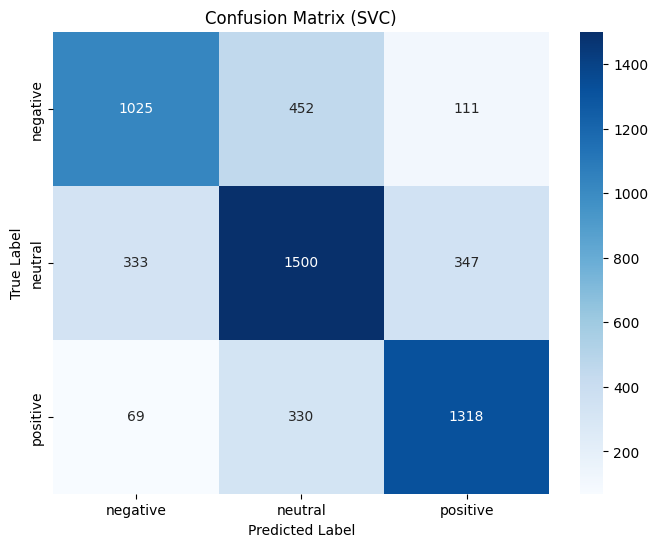

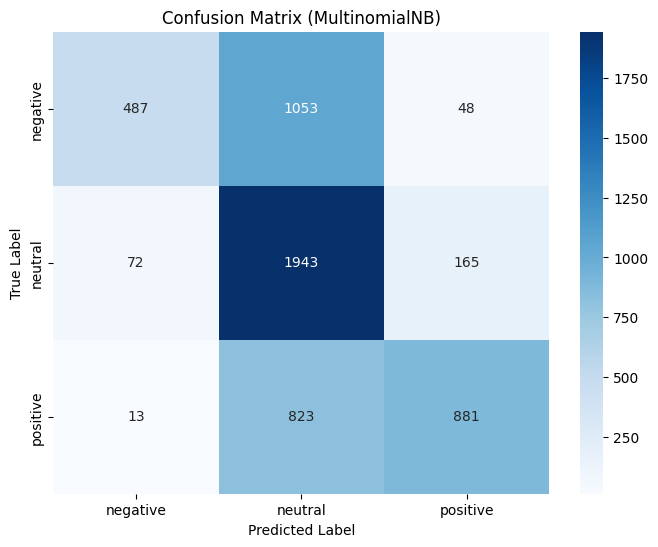

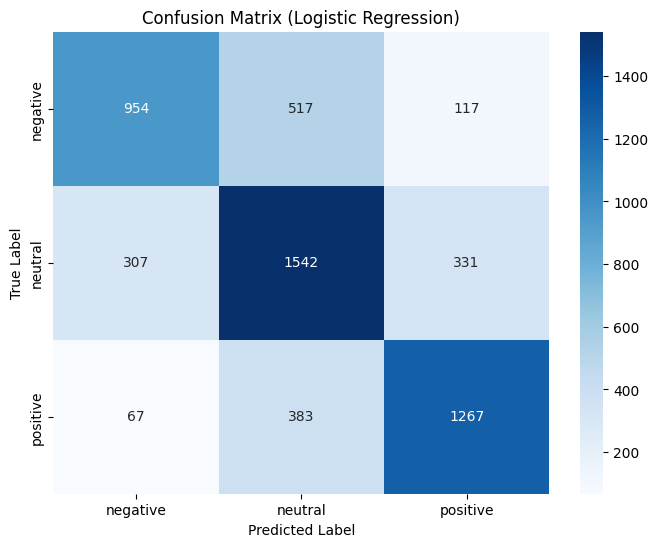

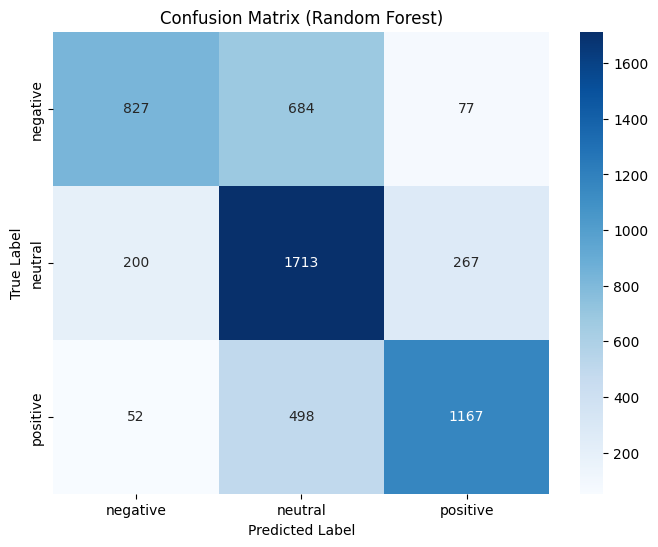

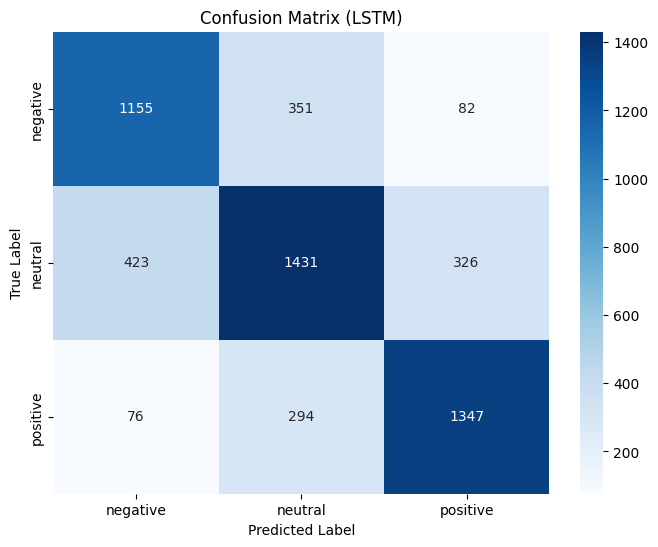

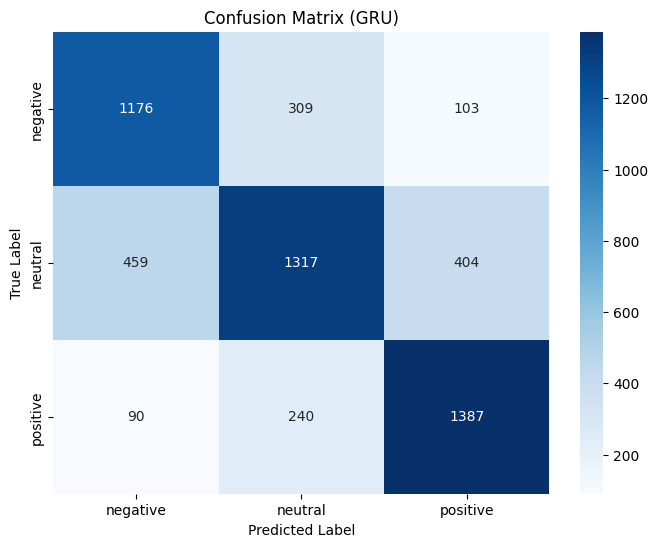

In [ ]:
def plot_confusion_matrix(cm, title):
  plt.figure(figsize=(8, 6))
  sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
              xticklabels=['negative', 'neutral', 'positive'],
              yticklabels=['negative', 'neutral', 'positive'])
  plt.xlabel("Predicted Label")
  plt.ylabel("True Label")
  plt.title(f"Confusion Matrix ({title})")
  plt.show()

plot_confusion_matrix(cm_svm, "SVC")
plot_confusion_matrix(cm_nb, "MultinomialNB")
plot_confusion_matrix(cm_lr, "Logistic Regression")
plot_confusion_matrix(cm_rf, "Random Forest")
plot_confusion_matrix(cm_lstm, "LSTM")
plot_confusion_matrix(cm_gru, "GRU")


Pada grafik diatas, dapat dilihat bahwa Model deep learning LSTM memiliki nilai akurasi dan f1 score terbaik dibanding lima model lainnya, dan MultinomialNB memiliki akurasi terendah. Sehingga model LSTM menjadi pilihan saya dalam project ini untuk melakukan analisis sentimen.

**Kesimpulan**